In [33]:
# Import necessary libraries
import transformers
import datasets
import pandas as pd
import pickle
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel, AutoConfig, Trainer, TrainingArguments, DebertaV2Tokenizer, TrainerCallback
from datasets import Dataset as HuggingFaceDataset
from torch import nn
from torch.nn import CrossEntropyLoss
from huggingface_hub import PyTorchModelHubMixin
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers.modeling_outputs import SequenceClassifierOutput
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load meta data from the pickle file created in "sentiment"
reviews_df = pd.read_pickle("./Saved datasets/reviews.pkl")
meta_df = pd.read_pickle("./Saved datasets/meta.pkl")

In [3]:
# Inspect dataframe shapes
print(f"Shape reviews: {reviews_df.shape}")
print(f"Shape meta: {meta_df.shape}")

Shape reviews: (2128605, 4)
Shape meta: (94327, 12)


In [5]:
# View column names of both datasets
print(f"Reviews columns: {reviews_df.columns}")
print(f"Meta columns: {meta_df.columns}")

Reviews columns: Index(['rating', 'title', 'text', 'parent_asin'], dtype='object')
Meta columns: Index(['main_category', 'title', 'average_rating', 'rating_number', 'features',
       'description', 'price', 'categories', 'details', 'parent_asin',
       'bought_together', 'subtitle'],
      dtype='object')


In [4]:
# Drop columns not needed for the categorisation
# Review data not needed for categorisation model

meta_clean = meta_df.drop(columns = [
    "average_rating", 
    "rating_number",
    "features",
    "description",
    "price",   
    "details",
    "bought_together",
    "subtitle" # mainly "none" 
    ]) 

In [13]:
# View column names left in dataset
print(f"Meta columns: {meta_clean.columns}")

Meta columns: Index(['main_category', 'title', 'categories', 'parent_asin'], dtype='object')


In [6]:
# Inspect shape after dropping columns
print(f"Shape meta: {meta_clean.shape}")

Shape meta: (94327, 4)


In [5]:
# Inspect unique values from "main_category"
unique_values = meta_clean["main_category"].unique()

print(unique_values)

['Industrial & Scientific' 'Tools & Home Improvement' 'Appliances'
 'Amazon Home' 'Computers' 'AMAZON FASHION' None 'Sports & Outdoors'
 'Automotive' 'Health & Personal Care' 'Camera & Photo'
 'Arts, Crafts & Sewing' 'All Electronics' 'Cell Phones & Accessories'
 'Baby' 'Musical Instruments' 'All Beauty' 'Grocery' 'Pet Supplies'
 'Office Products' 'Toys & Games' 'Home Audio & Theater'
 'GPS & Navigation' 'Premium Beauty' 'Video Games'
 'Portable Audio & Accessories' 'Software' 'Books' 'Digital Music'
 'Car Electronics' 'Movies & TV']


In [25]:
# Inspect head of meta_clean
print(meta_clean.head)

<bound method NDFrame.head of                   main_category  \
0       Industrial & Scientific   
1      Tools & Home Improvement   
2      Tools & Home Improvement   
3      Tools & Home Improvement   
4      Tools & Home Improvement   
...                         ...   
94322  Tools & Home Improvement   
94323  Tools & Home Improvement   
94324  Tools & Home Improvement   
94325  Tools & Home Improvement   
94326  Tools & Home Improvement   

                                                   title  \
0      ROVSUN Ice Maker Machine Countertop, Make 44lb...   
1      HANSGO Egg Holder for Refrigerator, Deviled Eg...   
2      Clothes Dryer Drum Slide, General Electric, Ho...   
3      154567702 Dishwasher Lower Wash Arm Assembly f...   
4                            Whirlpool W10918546 Igniter   
...                                                  ...   
94322                                          AMI PARTS   
94323  WP10442411 Refrigerator Defrost Thermostat Rep...   
94324    

In [7]:
# Check for missing values
print(meta_clean.isnull().sum())
print(meta_clean.isna().sum())

# We don't use the main category in our model, so no need to drop the rows with missing data

main_category    4676
title               0
categories          0
parent_asin         0
dtype: int64
main_category    4676
title               0
categories          0
parent_asin         0
dtype: int64


In [6]:
# Extract the last element of each array in category column
meta_clean["sub_category"] = meta_clean["categories"].apply(lambda x: x[-1] if len(x) > 0 else None)
print(meta_clean.head())

              main_category  \
0   Industrial & Scientific   
1  Tools & Home Improvement   
2  Tools & Home Improvement   
3  Tools & Home Improvement   
4  Tools & Home Improvement   

                                               title  \
0  ROVSUN Ice Maker Machine Countertop, Make 44lb...   
1  HANSGO Egg Holder for Refrigerator, Deviled Eg...   
2  Clothes Dryer Drum Slide, General Electric, Ho...   
3  154567702 Dishwasher Lower Wash Arm Assembly f...   
4                        Whirlpool W10918546 Igniter   

                                          categories parent_asin  \
0  [Appliances, Refrigerators, Freezers & Ice Mak...  B08Z743RRD   
1  [Appliances, Parts & Accessories, Refrigerator...  B097BQDGHJ   
2                  [Appliances, Parts & Accessories]  B00IN9AGAE   
3  [Appliances, Parts & Accessories, Dryer Parts ...  B0C7K98JZS   
4                  [Appliances, Parts & Accessories]  B07QZHQTVJ   

          sub_category  
0           Ice Makers  
1            Egg 

In [7]:
# Inspect unique values from "sub_category"
unique_values = meta_clean["sub_category"].unique()

print(unique_values)

['Ice Makers' 'Egg Trays' 'Parts & Accessories' 'Replacement Parts'
 'Drip Pans' 'Dishwasher Parts & Accessories' 'Handles' 'Reusable Filters'
 'Water Filters' None 'Knobs' 'Hoses' 'Accessories' 'Baskets'
 'Drain Pumps' 'Range Hoods' 'Refrigerator Parts & Accessories' 'Shelves'
 'Bins' 'Disposable Filters' 'Range Parts & Accessories' 'Refrigerators'
 'Filters' 'Milk Frothing Pitchers' 'Oven Parts & Accessories'
 'Built-In Dishwashers' 'Doors' 'Freezer Parts & Accessories'
 'Freestanding Ranges' 'Cooktop Parts & Accessories' 'Humidity Meters'
 'Washer Parts & Accessories' 'Beverage Refrigerators' 'Permanent Filters'
 'Vents' 'Portable Dryers' 'Kegerators' 'Cooktops' 'Bag Sealers'
 'Portable Washers' 'Ranges, Ovens & Cooktops' 'Washers' 'Dryers' 'Motors'
 'Humidifier Parts & Accessories' 'Single Wall Ovens' 'Burners'
 'Shrink Wrappers' 'Lint Screens' 'Range Hood Parts & Accessories'
 'Chest Freezers' 'Stacked Washer & Dryer Units' 'Replacement Wicks'
 'Upright Freezers' 'Washers & Dryers

In [7]:
# Define categories to use for model
categories = [
    "refrigerators, freezers and ice makers",
    "dishwashers, washers and dryers",
    "microwaves, ovens and grills",
    "parts and accessories",
    "small appliances",
    "mixed"
]

In [8]:
# Assign each sub_category to one of the 6 categories as labels
category_mapping = {
    "refrigerators, freezers and ice makers": 
    [
    'Refrigerators',
    'Beverage Refrigerators',
    'Kegerators',
    'Chest Freezers',
    'Upright Freezers',
    'Freezers',
    'Refrigerators',
    'Freezers & Ice Makers',
    'Ice Makers'
    ],
    
    "dishwashers, washers and dryers": 
    [
    'Built-In Dishwashers',
    'Portable Dryers',
    'Portable Washers',
    'Washers'
    'Dryers',
    'Stacked Washer & Dryer Units',
    'Washers & Dryers',
    'All-in-One Combination Washers & Dryers',
    'Countertop Dishwashers',
    'Dishwashers',
    'Portable Dishwashers'
    ],
    
    "microwaves, ovens and grills": 
    [
    'Cooktops',
    'Ranges, Ovens & Cooktops',
    'Single Wall Ovens',
    'Burners',
    'Grills',
    'Double Wall Ovens',
    'Combination Microwave & Wall Ovens',
    'Wall Ovens'
    ],
    
    "parts and accessories": 
    [
    'Parts & Accessories',
    'Replacement Parts',
    'Dishwasher Parts & Accessories',
    'Handles',
    'Reusable Filters',
    'Knobs',
    'Hoses',
    'Accessories',
    'Baskets',
    'Drain Pumps',
    'Range Hoods',
    'Refrigerator Parts & Accessories',
    'Shelves',
    'Disposable Filters',
    'Range Parts & Accessories',
    'Filters',
    'Oven Parts & Accessories',
    'Doors',
    'Freezer Parts & Accessories',
    'Cooktop Parts & Accessories',
    'Washer Parts & Accessories', 
    'Vents',
    'Drip Pans',
    'Humidifier Parts & Accessories',
    'Lint Screens',
    'Range Hood Parts & Accessories',
    'Replacement Wicks',
    'Absorption Sleeves', 
    'Chemicals'
    'Beverage Refrigerator Replacement Parts', 
    'Plug Receptacles',
    'Dryer Parts & Accessories',
    'Food Waste Disposer Parts & Accessories',
    'Trash Compactor Parts & Accessories',
    'Burner Rings',
    'Exhaust Fans', 
    'Kegerator Replacement Parts', 
    'Warming Drawers',
    'Oven Racks', 
    'Heating Elements',
    'Air Conditioner Parts & Accessories',
    'Fasteners',
    'Egg Trays',
    ],
    
    "small appliances": 
    [
    'Water Filters',
    'Bins',
    'Milk Frothing Pitchers',
    'Bag Sealers', 
    'Humidity Meters',
    'Permanent Filters',   
    'Trash Compactors', 
    'Motors', 
    'Shrink Wrappers',
    'Blowers',
    'Garbage Disposals & Compactors',
    'Irons & Garment Steamers',
    'Air Filters',
    'Steam Cleaners & Steam Mops' 
    ],
    
    "mixed": 
    [
    'Gerhards Appliances', 
    'US MA 3P AWAS 2020',  
    " ", 
    "None",
    'Freestanding Ranges', 
    'Slide-In Ranges',
    'Ranges',
    'LG Styler Steam Closets',
    'Drop-In Ranges', 
    'Laundry Appliances' 
    ]
}

In [9]:
# Assign new category to each sub_category

def get_category(product):
    for category, items in category_mapping.items():
        if product in items:
            return category
    return "mixed"    

# Apply the function to create a new column
meta_clean["category_new"] = meta_clean["sub_category"].apply(get_category)

print(meta_clean["category_new"].unique())

['refrigerators, freezers and ice makers' 'parts and accessories'
 'small appliances' 'mixed' 'dishwashers, washers and dryers'
 'microwaves, ovens and grills']


In [18]:
# Check for unassigned products

# Filter the dataframe for "Unknown" 
unknown_categories = meta_clean[meta_clean["category_new"] == "None"]

# Print or analyze the unknown entries
print(unknown_categories)

Empty DataFrame
Columns: [main_category, title, categories, parent_asin, sub_category, category_new]
Index: []


In [10]:
# Pickle dataframe with categories for use in generating model
meta_clean.to_pickle("./Saved datasets/meta_cat.pkl")

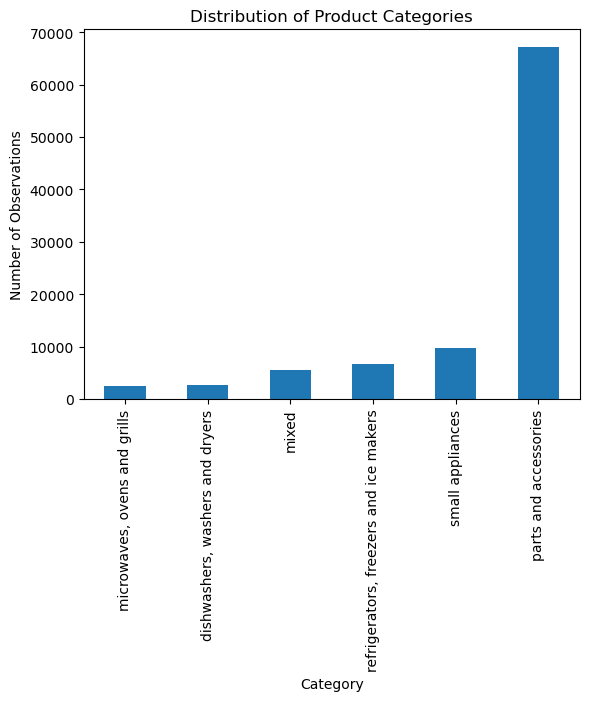

In [41]:
# View number of products per category

# Calculate the distribution of product categories and sort by values
category_distribution_sorted = meta_clean["category_new"].value_counts().sort_values(ascending=True)

# Plot the distribution as a bar chart
category_distribution_sorted.plot(kind='bar')

# Add title and labels
plt.title('Distribution of Product Categories')
plt.xlabel('Category')
plt.ylabel('Number of Observations')

# Show the plot
plt.show()

In [11]:
# Encode the categories as labels
le = LabelEncoder()
meta_clean["labels"] = le.fit_transform(meta_clean["category_new"])

# Display the data with the new "labels" column
print(meta_clean.head())

              main_category  \
0   Industrial & Scientific   
1  Tools & Home Improvement   
2  Tools & Home Improvement   
3  Tools & Home Improvement   
4  Tools & Home Improvement   

                                               title  \
0  ROVSUN Ice Maker Machine Countertop, Make 44lb...   
1  HANSGO Egg Holder for Refrigerator, Deviled Eg...   
2  Clothes Dryer Drum Slide, General Electric, Ho...   
3  154567702 Dishwasher Lower Wash Arm Assembly f...   
4                        Whirlpool W10918546 Igniter   

                                          categories parent_asin  \
0  [Appliances, Refrigerators, Freezers & Ice Mak...  B08Z743RRD   
1  [Appliances, Parts & Accessories, Refrigerator...  B097BQDGHJ   
2                  [Appliances, Parts & Accessories]  B00IN9AGAE   
3  [Appliances, Parts & Accessories, Dryer Parts ...  B0C7K98JZS   
4                  [Appliances, Parts & Accessories]  B07QZHQTVJ   

          sub_category                            category_new  lab

In [15]:
# View mapping of labels to original categories
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print('Label mapping:', label_mapping)

Label mapping: {'dishwashers, washers and dryers': 0, 'microwaves, ovens and grills': 1, 'mixed': 2, 'parts and accessories': 3, 'refrigerators, freezers and ice makers': 4, 'small appliances': 5}


In [12]:
# Randomly picking 6000 rows for training/ testing, since model takes very long
meta_small = meta_clean.sample(n=6000, random_state=42) # about 10%

In [13]:
# Define label and features columns
X = meta_small["title"]
y = meta_small["labels"]

# Split data into train and test using stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Check the size of the data sets
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (4200,), (4200,)
Test set: (1800,), (1800,)


In [16]:
# Slightly adjust model settings from model card for nvidia/domain-classifier to allow for changed categories

class CustomModel(nn.Module, PyTorchModelHubMixin):
    def __init__(self, config):
        super(CustomModel, self).__init__()
        # Load DeBERTa V3 base model for transfer learning
        self.model = AutoModel.from_pretrained(config.base_model_name)
        self.dropout = nn.Dropout(config.fc_dropout)
        self.fc = nn.Linear(self.model.config.hidden_size, len(config.id2label))

    def forward(self, input_ids, attention_mask, labels=None):
        features = self.model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        pooled_output = features[:, 0, :]  # Pooling the CLS token
        dropped = self.dropout(pooled_output)
        logits = self.fc(dropped)
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.fc.out_features), labels.view(-1))
        return SequenceClassifierOutput(loss=loss, logits=logits)

# Set up id2label and label2id using label_mapping
id2label = {v: k for k, v in label_mapping.items()}
label2id = {k: v for k, v in label_mapping.items()}

# Load configuration and update for our labels
config = AutoConfig.from_pretrained("nvidia/domain-classifier")
config.id2label = id2label
config.label2id = label2id
config.fc_dropout = 0.1
config.return_dict = True
config.base_model_name = "microsoft/deberta-v3-base"


In [14]:
# Check that labels and ids passed to the model are correct
print(id2label)
print(label2id)

{0: 'dishwashers, washers and dryers', 1: 'microwaves, ovens and grills', 2: 'mixed', 3: 'parts and accessories', 4: 'refrigerators, freezers and ice makers', 5: 'small appliances'}
{'dishwashers, washers and dryers': 0, 'microwaves, ovens and grills': 1, 'mixed': 2, 'parts and accessories': 3, 'refrigerators, freezers and ice makers': 4, 'small appliances': 5}


In [17]:
# Initialize the model with the updated configuration
model = CustomModel(config)

# Load tokenizer
tokenizer = DebertaV2Tokenizer.from_pretrained('microsoft/deberta-v3-base')

c:\Users\katha\anaconda3\envs\llm_torch\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [18]:
# Tokenize the X variable
def tokenize_texts(df, tokenizer):
    # Reset index again before tokenization 
    df = df.reset_index(drop=True)
    
    # Tokenize the text
    input_texts = df.tolist()
    tokenized_data = tokenizer(
        input_texts, 
        padding=True, 
        truncation=True, 
        max_length=512,  # Adjust max length if necessary
        return_tensors='pt'
    )
    
    return tokenized_data

X_train_tokenized = tokenize_texts(X_train, tokenizer)
X_test_tokenized = tokenize_texts(X_test, tokenizer)


In [19]:
# View the data after tokenization
print(X_train_tokenized)

{'input_ids': tensor([[    1, 47892, 26861,  ...,     0,     0,     0],
        [    1,   543, 60542,  ...,     0,     0,     0],
        [    1, 80899, 43827,  ...,     0,     0,     0],
        ...,
        [    1, 49521,   287,  ...,     0,     0,     0],
        [    1, 61101, 48313,  ...,     0,     0,     0],
        [    1, 76235, 10467,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


In [20]:
# Save the tokenized data as PyTorch tensors
torch.save(X_train_tokenized, './Saved datasets/X_train_tokenized.pt')
torch.save(X_test_tokenized, './Saved datasets/X_test_tokenized.pt')

In [21]:
# Load the data back after restarting machine
X_train_tokenized = torch.load('./Saved datasets/X_train_tokenized.pt')
X_test_tokenized = torch.load('./Saved datasets/X_test_tokenized.pt')

In [22]:
# Convert tokenized training data into dataset

# Extract tokenized inputs for training dataset
input_ids = X_train_tokenized['input_ids']
attention_masks = X_train_tokenized['attention_mask']
labels = y_train

# Prepare data for fine-tuning based on model requirements
class TokenizedDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        # Ensure all inputs are tensors, or convert them if they are not
        self.input_ids = [torch.tensor(ids, dtype=torch.long) if not isinstance(ids, torch.Tensor) else ids for ids in input_ids]
        self.attention_masks = [torch.tensor(mask, dtype=torch.long) if not isinstance(mask, torch.Tensor) else mask for mask in attention_masks]
        self.labels = [torch.tensor(label, dtype=torch.long) if not isinstance(label, torch.Tensor) else label for label in labels]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx].clone().detach(),
            'attention_mask': self.attention_masks[idx].clone().detach(),
            'labels': self.labels[idx].clone().detach()
        }

# Create training dataset
training_dataset = TokenizedDataset(input_ids, attention_masks, labels)


In [23]:
# Convert tokenized test data into dataset

# Extract tokenized inputs for test dataset
input_ids = X_test_tokenized['input_ids']
attention_masks = X_test_tokenized['attention_mask']
labels = y_test

# Create testing dataset
testing_dataset = TokenizedDataset(input_ids, attention_masks, labels)

In [24]:
# Print tokenized input shapes
print(f"input_ids shape: {input_ids.shape}")
print(f"attention_masks shape: {attention_masks.shape}")

input_ids shape: torch.Size([1800, 113])
attention_masks shape: torch.Size([1800, 113])


In [34]:
# Define model evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
        }

In [35]:
# Define custom class for saving of model output
class SavePredictionsCallback(TrainerCallback):
    def on_epoch_end(self, args, state, control, **kwargs):
        # Make predictions on evaluation dataset
        predictions, labels, _ = trainer.predict(trainer.eval_dataset)
        predicted_labels = np.argmax(predictions, axis=1)

        # Create dataframe for the current epoch predictions
        results_df = pd.DataFrame({
            'True Label': labels,
            'Predicted Label': predicted_labels
        })

        # Save predictions to a csv file, overwriting at each epoch
        results_df.to_csv('./Model outputs/categories.csv', index=False)
        print(f"Predictions for Epoch {state.epoch} saved.")

In [36]:
# Setting up training arguments
training_args = TrainingArguments(
    output_dir='./category_results',
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    eval_strategy="epoch",
    logging_dir='./logs',
    logging_strategy="epoch",
    save_strategy="epoch",
    logging_steps=10
)

In [37]:
# Initialize Trainer
trainer = Trainer(
    model=model,  
    args=training_args,
    train_dataset=training_dataset,
    eval_dataset=testing_dataset,
    compute_metrics=compute_metrics,
    callbacks=[SavePredictionsCallback] 
)


In [38]:
# Run fine-tuning
trainer.train()

 33%|███▎      | 132/396 [28:51<44:10, 10.04s/it]  






























 33%|███▎      | 132/396 [31:32<44:10, 10.04s/it]

Predictions for Epoch 1.0 saved.
{'loss': 0.4019, 'grad_norm': 12.61187744140625, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}

































                                         
                                                   
 33%|███▎      | 132/396 [34:13<44:10, 10.04s/it]


{'eval_loss': 0.45175740122795105, 'eval_accuracy': 0.8833333333333333, 'eval_f1': 0.8693771067011087, 'eval_precision': 0.8789676778579958, 'eval_recall': 0.8833333333333333, 'eval_runtime': 160.7539, 'eval_samples_per_second': 11.197, 'eval_steps_per_second': 0.18, 'epoch': 1.0}


 67%|██████▋   | 264/396 [1:03:12<22:24, 10.19s/it] 






























 67%|██████▋   | 264/396 [1:05:55<22:24, 10.19s/it]

Predictions for Epoch 2.0 saved.
{'loss': 0.3012, 'grad_norm': 1.8545974493026733, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}

































                                         
                                                   
 67%|██████▋   | 264/396 [1:08:38<22:24, 10.19s/it]


{'eval_loss': 0.44040435552597046, 'eval_accuracy': 0.8933333333333333, 'eval_f1': 0.8860710480512274, 'eval_precision': 0.8873865431024212, 'eval_recall': 0.8933333333333333, 'eval_runtime': 163.239, 'eval_samples_per_second': 11.027, 'eval_steps_per_second': 0.178, 'epoch': 2.0}


100%|██████████| 396/396 [1:36:32<00:00, 10.16s/it]   






























100%|██████████| 396/396 [1:39:13<00:00, 10.16s/it]

Predictions for Epoch 3.0 saved.
{'loss': 0.2058, 'grad_norm': 4.118606090545654, 'learning_rate': 0.0, 'epoch': 3.0}

































                                         
                                                   
100%|██████████| 396/396 [1:41:51<00:00, 10.16s/it]


{'eval_loss': 0.43660610914230347, 'eval_accuracy': 0.8966666666666666, 'eval_f1': 0.8922523861251814, 'eval_precision': 0.8920266084366557, 'eval_recall': 0.8966666666666666, 'eval_runtime': 157.6886, 'eval_samples_per_second': 11.415, 'eval_steps_per_second': 0.184, 'epoch': 3.0}



100%|██████████| 396/396 [1:41:54<00:00, 15.44s/it]

{'train_runtime': 6114.0658, 'train_samples_per_second': 2.061, 'train_steps_per_second': 0.065, 'train_loss': 0.30298037962480023, 'epoch': 3.0}


TrainOutput(global_step=396, training_loss=0.30298037962480023, metrics={'train_runtime': 6114.0658, 'train_samples_per_second': 2.061, 'train_steps_per_second': 0.065, 'total_flos': 0.0, 'train_loss': 0.30298037962480023, 'epoch': 3.0})

In [39]:
# Save the model and tokenizer to a directory
model.save_pretrained('./categoriser_model')
tokenizer.save_pretrained('./categoriser_model')

('./categoriser_model\\tokenizer_config.json',
 './categoriser_model\\special_tokens_map.json',
 './categoriser_model\\spm.model',
 './categoriser_model\\added_tokens.json')

In [42]:
# To load the model and tokenizer later
loaded_model = CustomModel.from_pretrained('./categoriser_model')
loaded_tokenizer = AutoTokenizer.from_pretrained('./categoriser_model')

In [43]:
# Make predictions on the test set
predictions, true_labels, metrics = trainer.predict(testing_dataset)

# Convert them to predicted class indices
predicted_class_indices = predictions.argmax(-1)

# Print the predicted classes and metrics
print("Predicted class indices:", predicted_class_indices)
print("True labels:", labels)
print("Metrics:", metrics)

100%|██████████| 29/29 [02:36<00:00,  5.41s/it]

Predicted class indices: [3 3 3 ... 3 3 3]
True labels: 4367     3
12506    3
22459    3
13774    3
31057    5
        ..
84977    5
58340    3
29694    3
43376    3
92327    3
Name: labels, Length: 1800, dtype: int32
Metrics: {'test_loss': 0.43660610914230347, 'test_accuracy': 0.8966666666666666, 'test_f1': 0.8922523861251814, 'test_precision': 0.8920266084366557, 'test_recall': 0.8966666666666666, 'test_runtime': 162.3071, 'test_samples_per_second': 11.09, 'test_steps_per_second': 0.179}


In [44]:
# Add a new column called 'predictions' to store the predicted labels
X_test['predictions'] = predicted_class_indices

# Step 5: Save the updated dataframe to a CSV file
X_test.to_csv('./Model outputs/test_predictions.csv', index=False)

print("Predictions saved to test_predictions.csv")

Predictions saved to test_predictions.csv


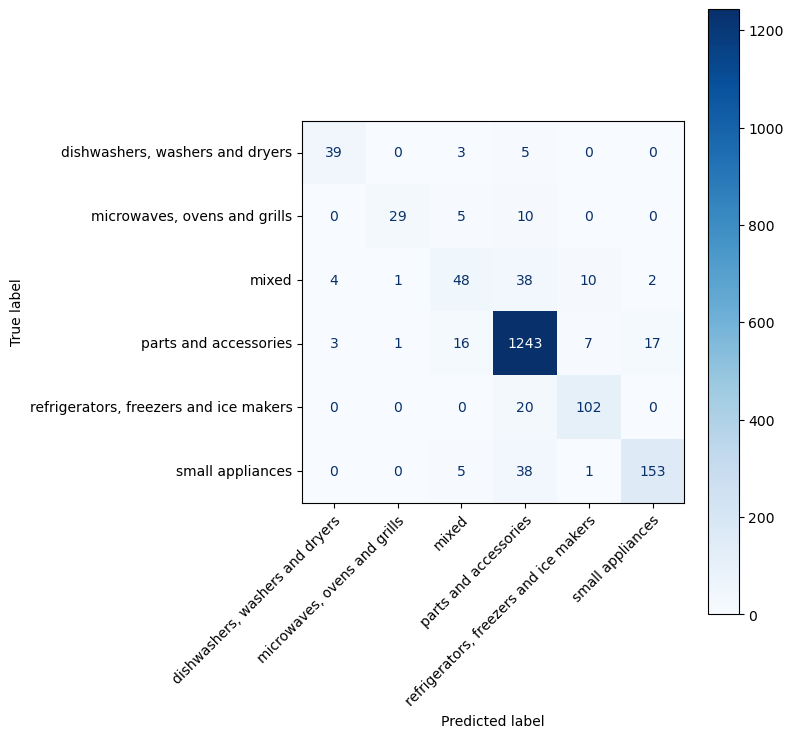

In [49]:
# Define the category names corresponding to your labels
category_names = le.classes_ 

# Plot the confusion matrix with the original category names on the axes
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=category_names)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))  
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)

# Set the tick parameters to avoid label overlap
ax.set_xticks(range(len(category_names)))  
ax.set_yticks(range(len(category_names)))
ax.set_xticklabels(category_names, rotation=45, ha="right", rotation_mode="anchor")  
ax.set_yticklabels(category_names, va="center")  

# Adjust layout to ensure labels are spaced evenly
plt.tight_layout()

# Show the plot
plt.show()